In [121]:
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from wordcloud import WordCloud

In [4]:
with open("rara_colors.json", "r", encoding="utf8") as f:
    rara_colors = json.load(f)
    rara_colors = list(rara_colors.values())

### Andmete import ja puhastus

In [5]:
df = pd.read_csv("erb_books.tsv", sep="\t", encoding="utf8")

C:\Users\krister.kruusmaa\AppData\Local\Temp\ipykernel_1844\602269067.py:1: DtypeWarning: Columns (4,26,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("erb_books.tsv", sep="\t", encoding="utf8")


In [6]:
# Valime välja olulisemad tulbad. Siin analüüsis ei ole ka neid kõiki vaja.
df = df[["ID", "creator", "title", "publication_place", "publisher", "publication_date", "physical_dimensions", "physical_extent", "physical_details",
         "subject_topic", "subject_topic_thesaurus", "subject_genre", "subject_genre_thesaurus", "contributor",]]

In [7]:
# Eemaldame puuduvad aastaarvu või suurusega kanded
df = df.dropna(axis=0, subset=["physical_dimensions", "publication_date"])
df = df.rename(columns={"physical_dimensions": "dims", "publication_date": "year"})

In [8]:
def clean_dimensions(dims: str):
    """Funktsioon suuruse välja puhastamiseks ja ühtlustamiseks"""
    dims = dims.strip().lstrip()
    if re.match("\d{1,3}\s?cm", dims):
        dims = dims.split("cm")[0].strip()
    elif re.match("\d{1,3}\s?cn", dims):
        dims = dims.split("cn")[0].strip()
    elif re.match("\d{1,3}\s?[x]\s?\d{1,3}\s?cm", dims):
        dims = dims.split("x")[-1].split(" cm")[0].strip()
    
    if re.match("\d{1,3}$", dims):
        return int(dims)
    else:
        return pd.NA

In [9]:
df["dims"] = df["dims"].apply(clean_dimensions)
df = df.dropna(axis=0, subset="dims")
df["dims"] = df["dims"].astype(int)

# Jätame alles vaid alla meetri pikkused raamatud.
# Sellest suuremate puhul on enamasti tegu katalogiseerimisveaga, ehkki ilmselt eksisteerib ka mõni päriselt nii suur raamat
df = df[(df["dims"] > 0) & (df["dims"] <= 100)]


In [10]:
def clean_date(date: str):
    """Funktsioon aastaarvu välja puhastamiseks ja ühtlustamiseks"""
    date = date.strip().lstrip("c ")
    if re.match("(tsens\.?|tsenseeritud)\s?\d{4}", date): # mõnel teosel on ilmumise asemel tsensuuri läbimise aeg
        date = date[-4:]
    elif re.match("\d{3}-\?", date): # Mõnel teosel teada vaid kümnend - sel juhul paigutame ta kümnendi keskele
        date = date.replace("-?", "5")
    
    if re.match("\d{4}$", date):
        return int(date)
    else:
        return pd.NA

In [11]:
df["year"] = df["year"].apply(clean_date)
df = df.dropna(axis=0, subset="year")
df["year"] = df["year"].astype(int)

# Toimetame vaid kannetega, mis jäävad vahemikku 1800-2023
df = df[(df["year"] < 2024) & (df["year"] >= 1800)]

In [12]:
# Märgime tabelis lisaks aastale ka kümnendi
decade_bins = range(1800, df.year.max()+10, 10)
df["decade"] = pd.cut(df.year, bins=decade_bins, labels=list(decade_bins)[:-1]).astype(int)

In [13]:
# Jaotame suurused vahemikeks. Siinsed vahemikud pole loodud mõne konkreetse reegli alusel, vaid on lihtsalt analüüsiks kõige sobivamad
bin_edges = [0, 10, 14, 16, 18, 20, 22, 26, 30, 40, 60, 100]
bins = pd.cut(df.dims, bins=bin_edges)
bin_labels = [f"{int(itv.left+1)}-{int(itv.right)} cm"  
                for itv in bins.cat.categories]

df["bin"] = pd.cut(df.dims, bins=bin_edges, labels=bin_labels)

### Analüüs

##### Üldine statistika

In [119]:
print("Raamatute arv peale andmete puhastamist:", len(df))

Raamatute arv peale andmete puhastamist: 189191


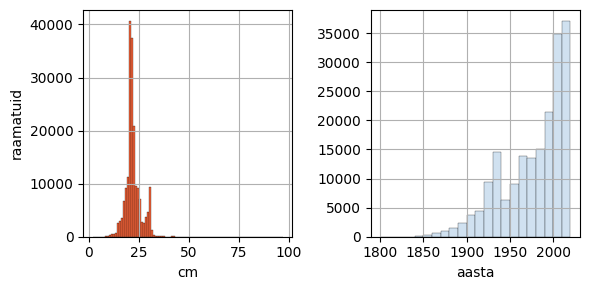

In [120]:
# Visualiseerime raamatute jaotuse suuruse ja ilmumiskümnendi järgi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))

df.dims.hist(ax=ax1, bins=(df.dims.max() - df.dims.min()), color=rara_colors[1], edgecolor="black", linewidth=0.2)
ax1.set_xlabel("cm", fontsize=10)
ax1.set_ylabel("raamatuid", fontsize=10)

df.decade.hist(ax=ax2, bins=len(decade_bins)-2, color=rara_colors[2], edgecolor="black", linewidth=0.2)
ax2.set_xlabel("aasta", fontsize=10)
#ax2.set_ylabel("raamatuid", fontsize=12)
fig.tight_layout()

plt.savefig("plots/stats.png", dpi=200, bbox_inches="tight")
plt.show()


In [16]:
# Kui palju igasse vahemikku raamatuid kuulub
df.bin.value_counts()

bin
21-22 cm     58221
19-20 cm     51994
23-26 cm     28586
27-30 cm     20382
17-18 cm     16002
15-16 cm      6568
11-14 cm      4309
31-40 cm      2447
1-10 cm        414
41-60 cm       253
61-100 cm       15
Name: count, dtype: int64

##### Suuruste osakaal ajalises lõikes

In [17]:
# Loome vahepealse tabeli järgmise graafiku jaoks
grouped_df = df.groupby(["bin", "decade"]).size().reset_index(name="count")
decade_sum = grouped_df.groupby("decade")["count"].sum()
grouped_df["share"] = grouped_df.groupby("decade")["count"].transform(lambda x: x / x.sum()).fillna(0)

grouped_df["decade"] = grouped_df["decade"].astype(str)
grouped_df["decade_datetime"] = pd.to_datetime(grouped_df["decade"]).dt.year
grouped_df["bin"] = grouped_df["bin"].astype(str)

In [125]:
def fake_ridgeplot(data, sigma=0.7, colors=None, alpha=1, hspace=-0.7, savepath=None):
    """Funktsioon suurustegraafiku jaoks.
    Graafik on "feik", kuna tegelik ridgeplot on mõeldud statistiliste jaotuste, mitte osakaalu visualiseerimiseks"""
    bins = data.bin.unique()
    
    gs = grid_spec.GridSpec(len(bins), 1)
    fig = plt.figure(figsize=(6, 6))

    i = 0
    ax_objs = []

    for bin_ in data.bin.unique():
        # creating new axes object and appending to ax_objs
        ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

        # plotting the distribution
        bin_df = data.loc[data["bin"] == bin_]
        line, = plt.plot(bin_df["decade"], gaussian_filter1d(bin_df["share"], sigma), color="black", linewidth="0.2")
        x = line.get_xdata()
        y = line.get_ydata()

        ax = ax_objs[-1]
        ax.fill_between(x,y, color=colors[i], alpha=alpha)

        #setting uniform x and y lims
        ax.set_ylim(0,0.8)
        ax.text(-2, 0, bin_, ha ="right", fontsize=10) #, fontweight="bold")

        # make background transparent
        rect = ax.patch
        rect.set_alpha(0)

        # remove borders, axis ticks, and labels
        ax.tick_params(axis="x", bottom=False)
        ax.tick_params(axis="y", left=False)
        ax.set_yticklabels('')
        ax.set_ylabel('')

        if i == len(bins)-1:
            ax.set_xticklabels(labels=[decade if int(decade)%50 == 0 else '' for decade in sorted(data.decade.unique())],
                               rotation=45,
                               fontsize=10)
                               #fontweight="bold")
        else:
            ax.set_xticklabels([])

        spines = ["top","right","left","bottom"]
        for s in spines:
            ax.spines[s].set_visible(False)

        i += 1    
    
    gs.update(hspace=hspace)
    fig.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")

    plt.show()

C:\Users\krister.kruusmaa\AppData\Local\Temp\ipykernel_1844\364666176.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[decade if int(decade)%50 == 0 else '' for decade in sorted(data.decade.unique())],
C:\Users\krister.kruusmaa\AppData\Local\Temp\ipykernel_1844\364666176.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


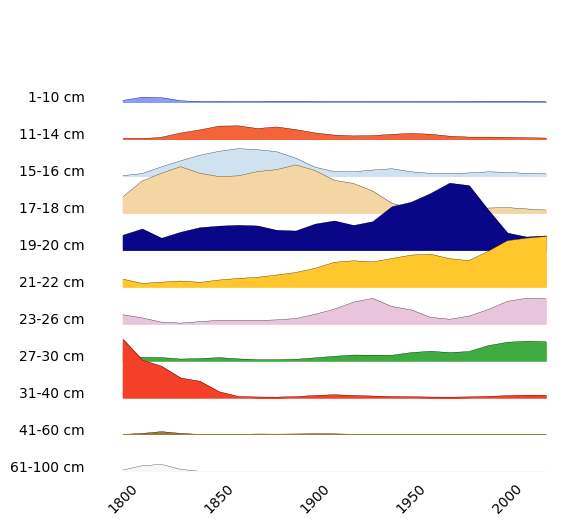

In [126]:
fake_ridgeplot(grouped_df, colors=rara_colors, alpha=1, hspace=-0.6, savepath="plots/ridgeplot.png")

##### Keskmise suuruse ajaline muutumine

In [127]:
# eraldi tabel vahemikuks 1800-1850
df1850 = df.loc[df.year < 1850]

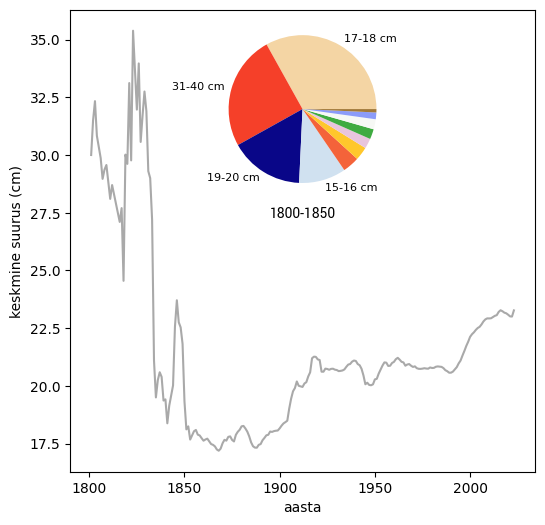

In [128]:
# joonis aritmeetilise keskmise muutumisest
fig, ax = plt.subplots(1, 1, figsize=(6,6))

df.groupby("year")["dims"].mean().rolling(5, min_periods=1).mean().plot(ax=ax, color="darkgrey")#), linestyle="dotted")
ax.set_xlabel("aasta", fontsize=10)
ax.set_ylabel("keskmine suurus (cm)", fontsize=10)

# loome graafiku sisse väikese ringdiagrammi 1800-1850 suuruste kohta
inset_ax = inset_axes(ax,
                    width="40%", # width = 30% of parent_bbox
                    height="40%", # height : 1 inch
                    loc="upper center")

dims1850 = df1850.bin.value_counts()
ordered_colors = dict(zip(df.bin.cat.categories, rara_colors[:len(df.bin.cat.categories)]))
pie_colors = [ordered_colors[dim] for dim in dims1850.index]
pie_labels = list(dims1850.index[:4]) + ['']*(len(dims1850)-4)
dims1850.plot.pie(ax=inset_ax, colors=pie_colors, labels=pie_labels, fontsize=8)
inset_ax.set_ylabel('')
inset_ax.set_xlabel("1800-1850", fontdict={"font": "Roboto"})

inset_ax.spines.bottom.set_color("black")

plt.savefig("plots/mean.png", dpi=200, bbox_inches="tight")
plt.show()


##### 1800-1850 eripärad

In [131]:
# Loeme üle žanrid, mis 19. sajandi esimesel poolel esinevad
genres1850 = df1850["subject_genre"].convert_dtypes().dropna().apply(lambda x: x.split("; ")).explode().value_counts()
genres1850.head()

subject_genre
publikaadid              24
õigusaktid               24
palveraamatud            16
evangeeliumid            13
vaimulik ilukirjandus    13
Name: count, dtype: int64

In [112]:
# teeme nende visualiseerimiseks sõnapilve objekti
wordcloud = WordCloud(background_color="white",
                      width=8000,
                      height=3000,
                      colormap="tab20",
                      font_path="RobotoSlab-Regular.ttf").generate_from_frequencies(genres1850)

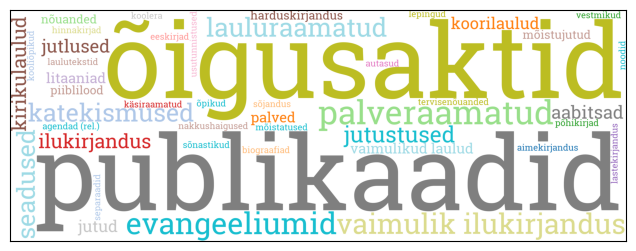

In [132]:
# sõnapilve visualiseerimine
fig, ax = plt.subplots(1, 1, figsize=(8,3))

ax.spines['bottom'].set_color("black")
ax.spines['top'].set_color("black")
ax.spines['right'].set_color("black")
ax.spines['left'].set_color("black")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.imshow(wordcloud)
plt.savefig("plots/wordcloud.png", dpi=300, bbox_inches="tight")
plt.show()

In [27]:
# Uurime, millised raamatud on selles vahemikus üle 60 cm suured
df1850.loc[df.bin=="61-100 cm"][["ID", "title", "publication_place", "subject_genre", "year", "dims"]]

,ID,title,publication_place,subject_genre,year,dims
118462,b16930460,Eesti Ma Rahwa Lühhikenne Palwe Ramat Seäl see...,Tallinn,palveraamatud,1823,93
119620,b17056901,Eesti-Ma-Rahwa Lühhikenne Palwe-Ramat Seäl see...,Tallinn,palveraamatud,1819,94
119832,b1708538x,Eesti Ma Rahwa Lühhikenne Palwe Ramat; Seäl se...,Tallinn,palveraamatud,1829,95


In [28]:
# Kerge ptsing digiarhiivis näitab, et need raamatud pole tegelikult meetri pikkused, vaid tegu on katalogiseerimisveaga.
# Eemaldame need tabelist
df1850b = df1850.drop([118462, 119620, 119832])

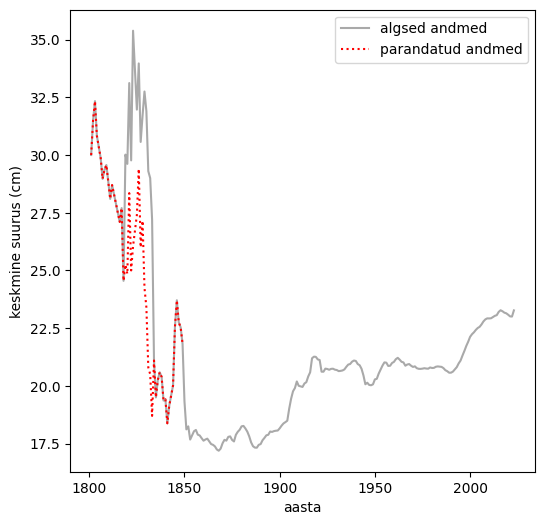

In [133]:
# Võrdleme eemaldatud kannetega keskmist varasema tulemusega
fig, ax = plt.subplots(1, 1, figsize=(6,6))

df.groupby("year")["dims"].mean().rolling(5, min_periods=1).mean().plot(ax=ax,
                                                                        color="darkgrey",
                                                                        label="algsed andmed")#, linestyle="dotted")

df1850b.groupby("year")["dims"].mean().rolling(5, min_periods=1).mean().plot(ax=ax,
                                                                             color="red",
                                                                             linestyle="dotted",
                                                                             label="parandatud andmed")

plt.legend()
plt.xlabel("aasta", fontsize=10)
plt.ylabel("keskmine suurus (cm)", fontsize=10)

plt.savefig("plots/mean2.png", dpi=200, bbox_inches="tight")
plt.show()


##### Kuumuskaart

In [135]:
# Peame andmeid veidi väänama, et luua žanr-suurus paarid
df_corr = df[["subject_genre", "bin"]].dropna(subset=["subject_genre"]).copy().rename(columns={"subject_genre": "genre"})
df_corr["genre"] = df_corr["genre"].apply(lambda x: x.split("; ")[0])
top_genres = df_corr["genre"].value_counts()[:30].index
df_corr = df_corr[df_corr["genre"].isin(top_genres)].copy()
df_corr["genre"] = df_corr["genre"].astype("category")

df_corr.head()

,genre,bin
0,ilukirjandus,19-20 cm
3,ilukirjandus,21-22 cm
4,artiklikogumikud,21-22 cm
5,ilukirjandus,17-18 cm
6,ilukirjandus,15-16 cm


In [136]:
# teeme koosesinemismaatriksi ja täidame selle suuruste ja žanrite paaride esinemise põhjal
df_heat = pd.DataFrame(0,
                       index=df_corr.genre.cat.categories,
                       columns=df_corr.bin.cat.categories
                       )

for ix, row in df_corr.iterrows():
    df_heat.loc[row["genre"], row["bin"]] += 1

heatmap_data = (df_heat.T/df_heat.T.sum(axis=0)).T # jagame tulemused žanri koguarvuga, et tulemus kajastaks suhtelisi sagedusi

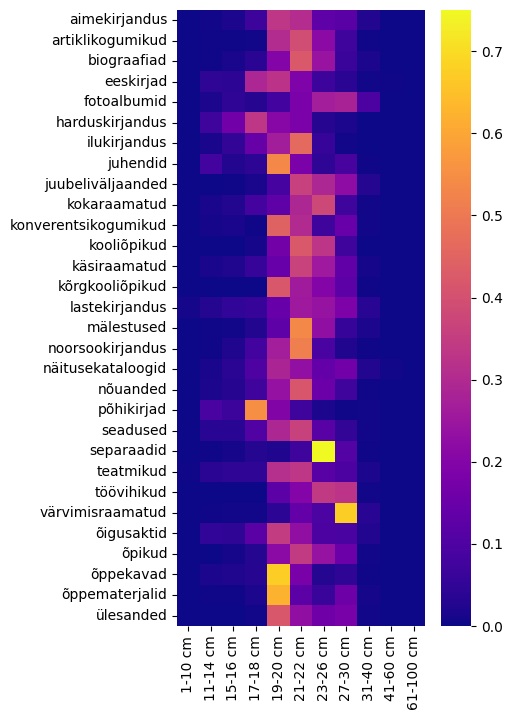

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(4,8))
sns.heatmap(heatmap_data, cmap="plasma", ax=ax)
plt.savefig("plots/heatmap.png", dpi=200, bbox_inches="tight")
plt.show()